In [2]:
import importlib
import modules

import matplotlib.pyplot as plt
import cellpylib as cpl
import numpy as np
import pandas as pd

In [6]:
import sys
sys.setrecursionlimit(10000)

Critical density: 0.23877551020408166


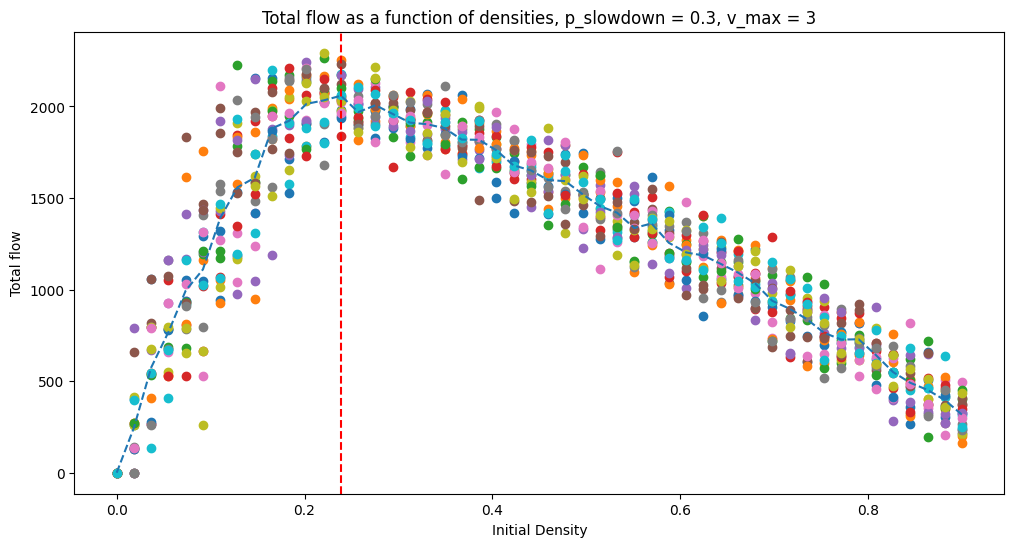

In [8]:
p = np.linspace(0.0, 0.9, 50)
L = 100
T = int(L / 2)
n = 20
p_slowdown = 0.3
v_max = 3

total_flows_per_density = dict()
average_flows_per_density = dict()

for density in p:
    lifespan_counter, jam_size_counter, evolutions = modules.run_model_stochastic(density, L, T, n, v_max=v_max, p_slowdown = p_slowdown, return_evolutions=True)
    

    total_flows = [modules.calculate_flow_nasch(evolution) for evolution in evolutions]
    average_flows = [flow / float(T) for flow in total_flows]
    
    total_flows_per_density[density] = total_flows
    average_flows_per_density[density] = average_flows

# Find critical point: the density for which the total flow average is maximum
mean_total_flow_per_density = {density: np.mean(flows) for density, flows in total_flows_per_density.items()}
critical_density = max(mean_total_flow_per_density, key=mean_total_flow_per_density.get)
print(f"Critical density: {critical_density}")

# plot total flow as a function of densities
plt.figure(figsize=(12,6))
plt.title(f'Total flow as a function of densities, p_slowdown = {p_slowdown}, v_max = {v_max}')
plt.plot(total_flows_per_density.keys(), total_flows_per_density.values(), 'o')
plt.plot(total_flows_per_density.keys(), [np.mean(flows) for flows in total_flows_per_density.values()], '--')

# Add a vertical line at the critical density
plt.axvline(x=critical_density, color='red', linestyle='--')

plt.xlabel('Initial Density')
plt.ylabel('Total flow')
plt.show()

In [ ]:
importlib.reload(modules)

p_values = np.linspace(0.0, 1, 30)
L = 100
T = int(L / 2)
n = 1
p_slowdown_values = np.linspace(0.0, 1, 30)
v_max_values = [x for x in range(1, 6)]
repetitions = 1

output_df = modules.find_critical_dataframe_nasch(p_slowdown_values, v_max_values, p_values, L, T, n, repetitions=repetitions)

# Save the output to a csv file
output_df.to_csv(f'Results\\critical_densities_nasch_n={n}_L={L}_T={T}_#p={len(p_values)}_reps={repetitions}.csv', index=False)

# Plot the output per v_max
for v_max in v_max_values:
    df = output_df[output_df[f'v_max'] == v_max]
    x = list(df['p_slowdown'])
    y = list(df['critical_density']) # multiple values per x
    y_means = [np.mean(l) for l in y]
    plt.figure(figsize=(12,6))
    plt.title(f'Critical density as a function of slowdown probability for v_max={v_max}')
    plt.plot(x, y, 'o', color='blue')
    plt.plot(x, y_means, '-', color='red')
    plt.xlabel('Slowdown probability')
    plt.ylabel('Critical density')
    plt.show()

 11%|█         | 28/250 [07:48<38:31, 10.41s/it]   

In [12]:
def density_evolution_nasch (evolution):
    """
    Function to calculate the density evolution of the NaSch model. The density is defined as the
    amount of cars in total. This is calculated by summing the total amount of cars.
    Input: 
    - evolution (list): List containing the evolution of the model for each timestep.
    Output:
    - density_evolution (list): List containing the density evolution of the model for each timestep.
    """
    location_evolution = [[x[0] for x in line] for line in evolution]
    density_evolution = [np.sum(line) / len(line) for line in location_evolution]
    return density_evolution


Flow: 24


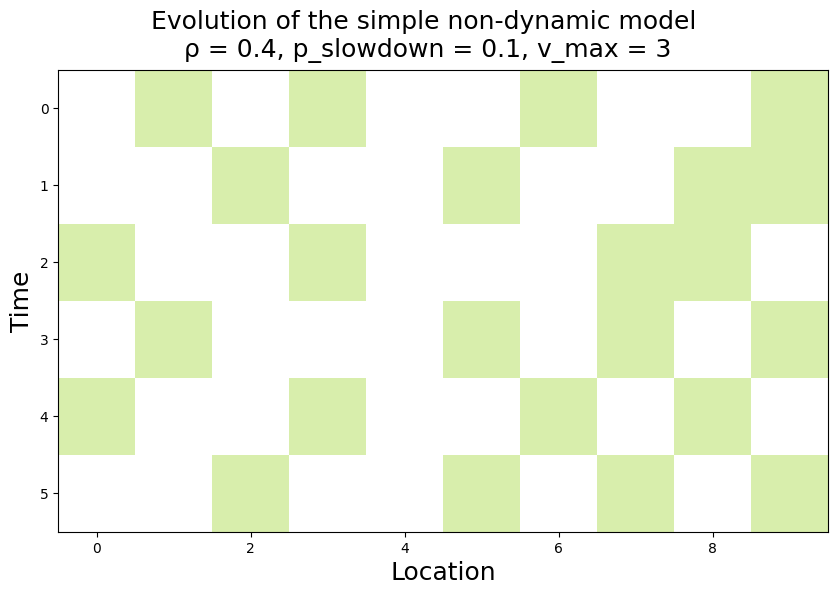

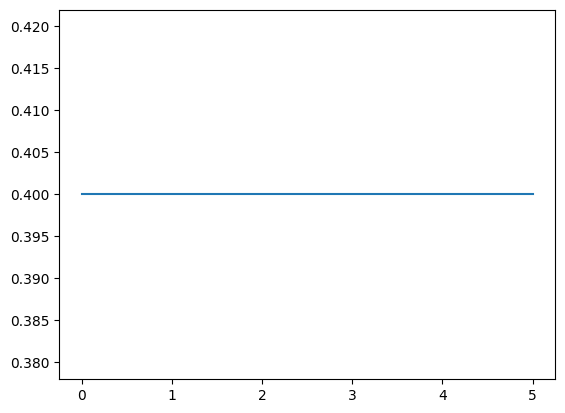

In [126]:
# Test non-dynamic model
importlib.reload(modules)

initial_density = 0.4
L = 10
T = 5
n = 1

# NaSch parameters
p_slowdown = 0.1
v_max = 3

lifespan_counter, jam_size_counter, evolutions = modules.run_model_stochastic(initial_density, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                      return_evolutions=True, dynamic_model=False)

# Visualize the evolution
evolution = evolutions[0]

location_evolution = [[x[0] for x in line] for line in evolution]
speed_evolution = [[x[1] for x in line] for line in evolution]

flow = modules.calculate_flow_nasch(evolution)
print(f"Flow: {flow}")

# Create your own colormap from hexcode
from matplotlib.colors import LinearSegmentedColormap
colors = ["#ffffff", "#d8eeac"]

colormap = LinearSegmentedColormap.from_list("my_colormap", colors)

# plot the car evolution
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
fig.suptitle(f"Evolution of the simple non-dynamic model \nρ = {initial_density}, p_slowdown = {p_slowdown}, v_max = {v_max}", fontsize=18)
cpl.plot(location_evolution, colormap=colormap,
         xlabel='Location', ylabel='Time')

density_test = density_evolution_nasch(evolution)
plt.plot(density_test)



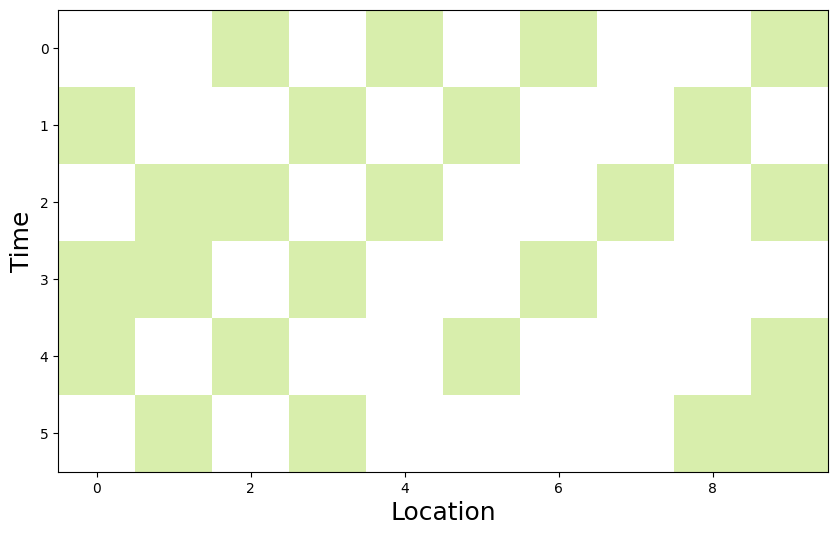

Flow: 27


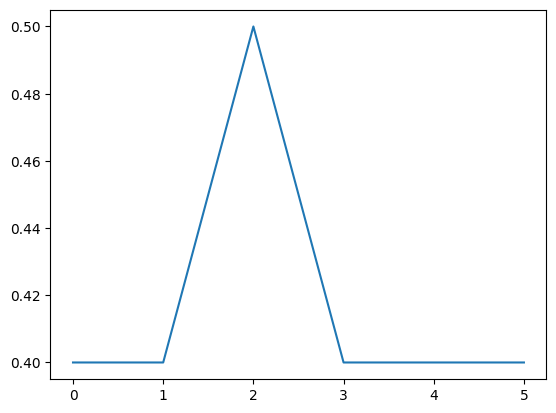

In [204]:
# Test dynamic model (with dynamics actually shown)
importlib.reload(modules)

initial_density = 0.4
L = 10
T = 5
n = 1

# NaSch parameters
p_slowdown = 0.1
v_max = 3

# Dynamic parameters
neighbourhood_size = 3
entry_chance = 0.05
exit_chance = 0.05

while True:

    lifespan_counter, jam_size_counter, evolutions = modules.run_model_stochastic(initial_density, L, T, n, v_max=v_max, p_slowdown = p_slowdown, 
                                                                        return_evolutions=True, dynamic_model=True, neighbourhood_size=neighbourhood_size,
                                                                        entry_chance=entry_chance, exit_chance=exit_chance)

    # Visualize the evolution
    evolution = evolutions[0]

    location_evolution = [[x[0] for x in line] for line in evolution]
    speed_evolution = [[x[1] for x in line] for line in evolution]

    flow = modules.calculate_flow_nasch(evolution)


    density_test = density_evolution_nasch(evolution)

    # Check if density goes up and down, and first density = initial_density
    up = False
    down = False
    
    for i in range(1, len(density_test)):
        if density_test[i] > density_test[i-1]:
            up = True
        if density_test[i] < density_test[i-1]:
            down = True
    
    if up and down and density_test[0] == initial_density:
        break

# Create your own colormap from hexcode
from matplotlib.colors import LinearSegmentedColormap
colors = ["#ffffff", "#d8eeac"]

colormap = LinearSegmentedColormap.from_list("my_colormap", colors)

# plot the car evolution
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
ax.set_xlabel(ax.get_xlabel(), fontsize=18)
ax.set_ylabel(ax.get_ylabel(), fontsize=18)
# fig.suptitle(f"Evolution of dynamic model \ninitial ρ = {initial_density}, p_slowdown = {p_slowdown}, v_max = {v_max},\nentry_chance = {entry_chance}, exit_chance = {exit_chance}, neighbourhood_size = {neighbourhood_size}", 
            #  fontsize=18)
cpl.plot(location_evolution, colormap=colormap,
         xlabel='Location', ylabel='Time')

print(f"Flow: {flow}")
plt.plot(density_test)

Cluster Sizes: [4]
Cluster Lifespans: [2]


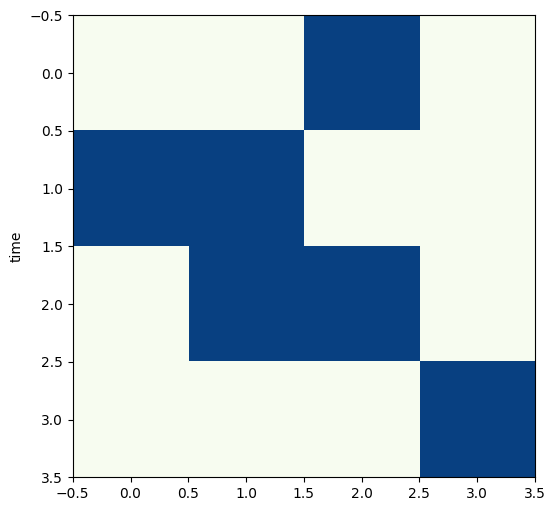

Cluster Sizes: [9, 2]
Cluster Lifespans: [5, 2]


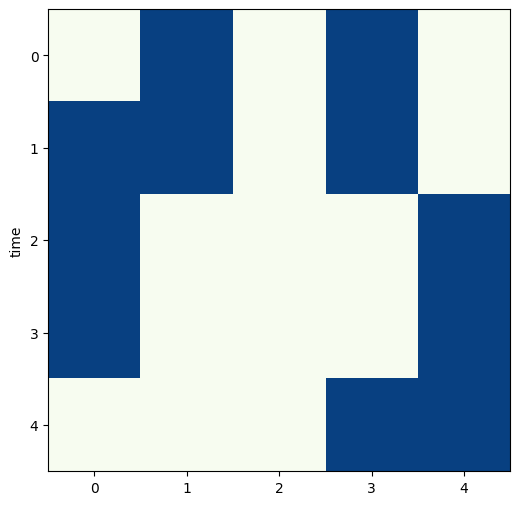

In [205]:
importlib.reload(modules)

modules.test_new_jam_finder()